In [1]:
import sys
import statistics

from qetu_sim import *

import numpy as np
import scipy.linalg
import itertools
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import Permutation
from qiskit.visualization import *
from qiskit_aer import AerSimulator

In [2]:
u = 1
t = 1
delta_t = 1
n = 1
num_sites = 4

In [3]:
H_ref = ref_fh_hamiltonian(u=u, t=t, WMI_qubit_layout=True, include_aux=True)
λ, v = np.linalg.eigh(H_ref)
ground_state_energy = λ[0]
ground_state_vector = v[:,0]

In [4]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
pauli_error, depolarizing_error, thermal_relaxation_error)
error_1q = 1e-3
error_2q = 1e-2
error_readout = 1e-1

# QuantumError objects
depol_error_1 = depolarizing_error(error_1q, 1)
depol_error_2 = depolarizing_error(error_2q, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_error_1, ["sx", "sy", "x", "y"])
noise_model.add_all_qubit_quantum_error(depol_error_2, ["cp", "pswap"])

noise_model.add_basis_gates(['unitary'])

In [5]:
#noise_model = define_noise_model(t1=200e3, t2=300e3, duration_1q=20, duration_2q=60, duration_readout=1500, fidelity_1q=0.999, fidelity_2q=0.995, fidelity_readout=0.98)

sim_ideal = AerSimulator()
sim_noise = AerSimulator(noise_model=noise_model)

simulator = sim_ideal

degree_list = range(1,51,1)
trotter_steps_list = range(1,2)
energy_estimation_list = []
overlap_list = []
statevector_list = []

for degree in degree_list:
    E_min, E_mu_m, E_mu_p, E_max = calculate_qsp_params(u, t)
    qsp = QSPPhase()
    phi_seq_su2 = qsp.cvx_qsp_heaviside(
        degree,
        E_min,
        E_mu_m, 
        E_mu_p, 
        E_max
    )
    #phi_vec = convert_Zrot_to_Xrot(phi_seq_su2)
    phi_vec = phi_seq_su2
    for trotter_steps in trotter_steps_list:
        print("Degree: " + str(degree) + "\t Trotter steps: " + str(trotter_steps))
        # Construct quantum circuit
        QETU_circ = construct_QETU_circ(u, t, trotter_steps, phi_vec)
        QETU_circ_WMI = transpile_QETU_to_WMI(QETU_circ)
        QETU_circ_WMI = add_pswap_labels(QETU_circ_WMI)
        QETU_circ_WMI = add_sy_labels(QETU_circ_WMI)
        onsite_circ_WMI, hop_1_circ_WMI, hop_2_circ_WMI = create_energy_estimation_circuits(QETU_circ_WMI)
        hop_2_circ_WMI = add_pswap_labels(hop_2_circ_WMI)
        hop_2_circ_WMI = add_sy_labels(hop_2_circ_WMI)        
        # estimate ground state
        energy_shots = []
        E0_meas = estimate_ground_state_energy_from_circ(onsite_circ_WMI, hop_1_circ_WMI, hop_2_circ_WMI, u=1, t=1, num_shots=10_000)
        energy_shots.append(E0_meas)
        energy_estimation_list.append(energy_shots)
        print("E0_meas: " + str(E0_meas))
        print("|E0 - E0_meas|: " + str(abs(ground_state_energy - E0_meas)))        


starting matlab engine..
Degree: 1	 Trotter steps: 1
E0_meas: -11.035234040752833
|E0 - E0_meas|: 11.608757786073944

starting matlab engine..

stopping matlab engine..
Degree: 2	 Trotter steps: 1
E0_meas: -14.712696041822255
|E0 - E0_meas|: 7.931295785004522

starting matlab engine..

stopping matlab engine..
Degree: 3	 Trotter steps: 1
E0_meas: -9.476001158382934
|E0 - E0_meas|: 13.167990668443844

starting matlab engine..

stopping matlab engine..
Degree: 4	 Trotter steps: 1
E0_meas: -6.245792572884595
|E0 - E0_meas|: 16.39819925394218

starting matlab engine..

stopping matlab engine..
Degree: 5	 Trotter steps: 1
E0_meas: -8.45138659028049
|E0 - E0_meas|: 14.192605236546287

starting matlab engine..

stopping matlab engine..
Degree: 6	 Trotter steps: 1
E0_meas: -14.596328510594734
|E0 - E0_meas|: 8.047663316232043

starting matlab engine..

stopping matlab engine..
Degree: 7	 Trotter steps: 1
E0_meas: -11.309175655529247
|E0 - E0_meas|: 11.33481617129753

starting matlab engine..


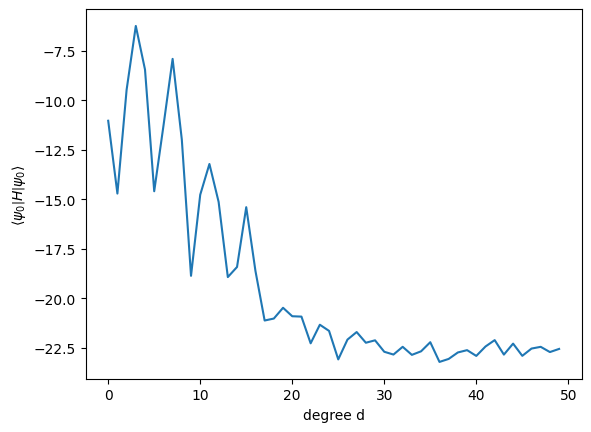

In [11]:
plt.xlabel("degree d")
plt.ylabel("$ \left \langle \psi_0 \middle| H \middle| \psi_0 \\right \\rangle $")
plt.plot(energy_estimation_list)